## 1. Setup and Imports

In [1]:
import os
import re
import random
import json
from pathlib import Path
from datasets import Dataset, DatasetDict, concatenate_datasets
import pandas as pd

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
from peft import LoraConfig, get_peft_model

import numpy as np
from sklearn.metrics import (
    precision_recall_fscore_support, 
    accuracy_score, 
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

## 2. Data Paths and Loading

In [2]:
# Define data paths
TRAIN_DIR = Path(r"C:\Users\nmilo\OneDrive\Desktop\Master\Semester2\NLP\project\dataset\train")
DEV_DIR   = Path(r"C:\Users\nmilo\OneDrive\Desktop\Master\Semester2\NLP\project\dataset\dev")
TEST_DIR  = Path(r"C:\Users\nmilo\OneDrive\Desktop\Master\Semester2\NLP\project\dataset\test")

# Verify paths exist
assert TRAIN_DIR.exists(), f"Train directory not found: {TRAIN_DIR}"
assert DEV_DIR.exists(),   f"Dev directory not found: {DEV_DIR}"
assert TEST_DIR.exists(),  f"Test directory not found: {TEST_DIR}"

def load_docie_docs(folder: Path, recursive: bool = False):
    """Load DocIE documents from JSON files"""
    docs = []
    pattern = "**/*.json" if recursive else "*.json"
    for file in folder.glob(pattern):
        data = json.loads(file.read_text(encoding="utf-8"))
        if isinstance(data, list):
            docs.extend(data)
        else:
            docs.append(data)
    return docs

# Load datasets
train_docs = load_docie_docs(TRAIN_DIR)
dev_docs   = load_docie_docs(DEV_DIR)
test_docs  = load_docie_docs(TEST_DIR, recursive=True)

print(f"Loaded - Train: {len(train_docs)} | Dev: {len(dev_docs)} | Test: {len(test_docs)}")

Loaded - Train: 51 | Dev: 23 | Test: 248


## 3. Exploratory Data Analysis

Top 10 Relation Types:
  HasPart: 82
  HasEffect: 67
  DiplomaticRelation: 45
  LocatedIn: 44
  InterestedIn: 38
  OwnerOf: 32
  NominatedFor: 25
  SaidToBeTheSameAs: 25
  PartOf: 18
  Creator: 17

Total relation types: 68
Total relation instances: 611


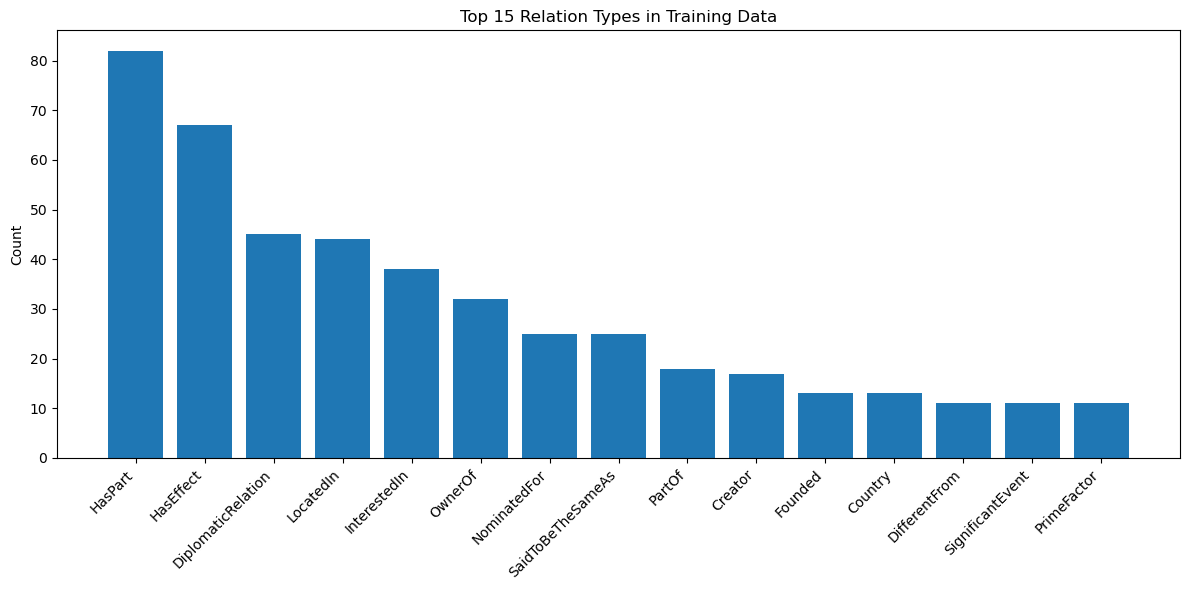

In [3]:
# Analyze relation types in training data
from collections import Counter

relation_counts = Counter(triple["relation"] for doc in train_docs for triple in doc["triples"])
print("Top 10 Relation Types:")
for relation, count in relation_counts.most_common(10):
    print(f"  {relation}: {count}")

print(f"\nTotal relation types: {len(relation_counts)}")
print(f"Total relation instances: {sum(relation_counts.values())}")

# Visualize relation distribution
plt.figure(figsize=(12, 6))
top_relations = relation_counts.most_common(15)
relations, counts = zip(*top_relations)
plt.bar(range(len(relations)), counts)
plt.xticks(range(len(relations)), relations, rotation=45, ha='right')
plt.title('Top 15 Relation Types in Training Data')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 4. Relation Extraction Data Preparatio

In [4]:
def create_re_examples(docs, split_name):
    """
    Create relation extraction examples from DocIE documents.
    For each document, create positive examples from triples and negative examples
    by randomly sampling entity pairs that don't have relations.
    """
    examples = []
    
    for doc in docs:
        # Skip documents without triples or entities
        if not doc.get("triples") or not doc.get("entities"):
            continue
            
        # Get document text
        text = doc.get("doc") or doc.get("document")
        if not text:
            continue
            
        # Extract all entity mentions (first mention of each entity)
        entity_mentions = [ent["mentions"][0] for ent in doc["entities"] if ent.get("mentions")]
        
        # Create set of positive relation pairs
        positive_pairs = {(triple["head"], triple["tail"]) for triple in doc["triples"]}
        
        # Create positive examples
        for triple in doc["triples"]:
            examples.append({
                "split": split_name,
                "sentence": text,
                "head": triple["head"],
                "tail": triple["tail"],
                "label": triple["relation"],
            })
            
        # Create negative examples (same number as positive)
        negative_count = 0
        max_attempts = len(doc["triples"]) * 10  # Avoid infinite loops
        attempts = 0
        
        while negative_count < len(doc["triples"]) and attempts < max_attempts:
            attempts += 1
            if len(entity_mentions) < 2:
                break
                
            head, tail = random.sample(entity_mentions, 2)
            if (head, tail) not in positive_pairs and (tail, head) not in positive_pairs:
                examples.append({
                    "split": split_name,
                    "sentence": text,
                    "head": head,
                    "tail": tail,
                    "label": "no_relation",
                })
                negative_count += 1
    
    return examples

# Create relation extraction examples
print("Creating RE examples...")
train_examples = create_re_examples(train_docs, "train")
dev_examples = create_re_examples(dev_docs, "dev")
test_examples = create_re_examples(test_docs, "test")

print(f"RE Examples - Train: {len(train_examples)} | Dev: {len(dev_examples)} | Test: {len(test_examples)}")

# Analyze label distribution
all_examples = train_examples + dev_examples
label_counts = Counter(ex["label"] for ex in all_examples)
print(f"\nLabel distribution:")
for label, count in label_counts.most_common():
    print(f"  {label}: {count}")

Creating RE examples...
RE Examples - Train: 1222 | Dev: 606 | Test: 0

Label distribution:
  no_relation: 914
  HasPart: 135
  HasEffect: 107
  LocatedIn: 47
  SaidToBeTheSameAs: 46
  DiplomaticRelation: 45
  InterestedIn: 38
  NominatedFor: 37
  OwnerOf: 34
  InfluencedBy: 24
  ApprovedBy: 24
  Uses: 24
  UsedBy: 20
  Creator: 20
  PartOf: 19
  BasedOn: 19
  Affiliation: 18
  ContributedToCreativeWork: 18
  Causes: 15
  Founded: 14
  Country: 14
  DifferentFrom: 13
  SignificantEvent: 11
  PrimeFactor: 11
  HasWorksInTheCollection: 10
  Follows: 10
  FollowedBy: 10
  PublishedIn: 10
  Studies: 9
  InspiredBy: 9
  SharesBorderWith: 8
  AdjacentStation: 7
  PositionHeld: 6
  OfficialLanguage: 5
  IssuedBy: 5
  WorkLocation: 4
  Partner: 4
  PracticedBy: 4
  AcademicDegree: 3
  Author: 3
  CountryOfCitizenship: 3
  EducatedAt: 3
  LanguageUsed: 3
  FieldOfWork: 3
  FoundedBy: 3
  MemberOf: 2
  Continent: 2
  OwnedBy: 2
  Location: 2
  LanguageOfWorkOrName: 2
  NativeLanguage: 2
  Origin

## 5. Data Preprocessing and Tokenization

In [5]:
# Create label mappings
all_labels = sorted(set(ex["label"] for ex in train_examples + dev_examples))
label2id = {label: idx for idx, label in enumerate(all_labels)}
id2label = {idx: label for label, idx in label2id.items()}

print(f"Number of relation classes: {len(all_labels)}")
print("Label mappings created")

# Initialize tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
max_length = 128

def tokenize_re_examples(examples):
    """
    Tokenize relation extraction examples.
    Format: [HEAD] [SEP] [TAIL] [SEP] [SENTENCE]
    """
    sentences = []
    labels = []
    
    for example in examples:
        # Create input text with special format
        input_text = f"{example['head']} [SEP] {example['tail']} [SEP] {example['sentence']}"
        sentences.append(input_text)
        labels.append(label2id[example["label"]])
    
    # Tokenize
    tokenized = tokenizer(
        sentences,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt"
    )
    
    return {
        "input_ids": tokenized["input_ids"],
        "attention_mask": tokenized["attention_mask"],
        "labels": torch.tensor(labels)
    }

# Create datasets
train_dataset = Dataset.from_list(train_examples)
dev_dataset = Dataset.from_list(dev_examples)

# Apply tokenization
def tokenize_function(examples):
    return tokenizer(
        [f"{head} [SEP] {tail} [SEP] {sentence}" for head, tail, sentence in 
         zip(examples["head"], examples["tail"], examples["sentence"])],
        truncation=True,
        padding=True,
        max_length=max_length
    )

train_dataset = train_dataset.map(
    lambda examples: {
        **tokenize_function(examples),
        "labels": [label2id[label] for label in examples["label"]]
    },
    batched=True,
    remove_columns=["split", "sentence", "head", "tail", "label"]
)

dev_dataset = dev_dataset.map(
    lambda examples: {
        **tokenize_function(examples),
        "labels": [label2id[label] for label in examples["label"]]
    },
    batched=True,
    remove_columns=["split", "sentence", "head", "tail", "label"]
)

# Set format for PyTorch
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
dev_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

print("Tokenization completed")

Number of relation classes: 76
Label mappings created


Map:   0%|          | 0/1222 [00:00<?, ? examples/s]

Map:   0%|          | 0/606 [00:00<?, ? examples/s]

Tokenization completed


## 6. Evaluation Metrics

In [6]:
def compute_metrics_re(eval_pred):
    """Compute F1 score and accuracy for relation extraction"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Filter out padding tokens
    mask = labels != -100
    predictions = predictions[mask]
    labels = labels[mask]
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="micro", zero_division=0
    )
    accuracy = accuracy_score(labels, predictions)
    
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy
    }

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## 7. BERT Baseline

In [7]:
def train_bert_baseline():
    """Train BERT baseline for relation extraction"""
    print("Training BERT Baseline...")
    
    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir="outputs/bert-re-baseline",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        learning_rate=2e-5,
        weight_decay=0.01,
        logging_steps=50,
        save_total_limit=1,
        fp16=torch.cuda.is_available()
    )
    
    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_re
    )
    
    # Train
    trainer.train()
    
    # Evaluate
    results = trainer.evaluate()
    print(f"Baseline Results - F1: {results['eval_f1']:.4f}, Accuracy: {results['eval_accuracy']:.4f}")
    
    return trainer, results

# Train baseline
baseline_trainer, baseline_results = train_bert_baseline()

Training BERT Baseline...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\2606987897.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,2.569600,2.657969,0.500000,0.500000,0.500000,0.500000
2,2.102600,2.493723,0.500000,0.500000,0.500000,0.500000
3,1.737300,2.484787,0.508251,0.508251,0.508251,0.508251


Baseline Results - F1: 0.5083, Accuracy: 0.5083


## 8. Hyperparameter Tuning - Full Fine-Tuning

In [8]:
def bert_ft_objective(trial):
    """Objective function for hyperparameter tuning"""
    # Suggest hyperparameters
    lr = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    
    # Create model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )
    
    # Training arguments
    args = TrainingArguments(
        output_dir=f"tmp/bert-re-ft-{trial.number}",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,
        evaluation_strategy="steps",
        eval_steps=20,
        logging_steps=10,
        save_strategy="no",
        max_steps=100,
        learning_rate=lr,
        fp16=torch.cuda.is_available(),
    )
    
    # Trainer
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_re,
    )
    
    trainer.train()
    results = trainer.evaluate()
    return results["eval_f1"]

# Run hyperparameter optimization
print("Starting hyperparameter tuning for Full Fine-Tuning...")
study_ft = optuna.create_study(direction="maximize")
study_ft.optimize(bert_ft_objective, n_trials=8)

print(f"Best FT params: {study_ft.best_params} → Dev-F1 = {study_ft.best_value:.4f}")
best_ft_params = study_ft.best_params

[I 2025-05-26 11:29:06,812] A new study created in memory with name: no-name-7113ee68-e46a-4914-9e25-88072d4b21ac


Starting hyperparameter tuning for Full Fine-Tuning...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\3142384169.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.956300,3.783016,0.348185,0.348185,0.348185,0.348185
40,3.442400,3.326602,0.500000,0.500000,0.500000,0.500000
60,3.125900,3.070314,0.500000,0.500000,0.500000,0.500000
80,2.604200,2.955680,0.500000,0.500000,0.500000,0.500000
100,2.713300,2.905957,0.500000,0.500000,0.500000,0.500000


[I 2025-05-26 11:34:15,015] Trial 0 finished with value: 0.5 and parameters: {'learning_rate': 1.2865942200426882e-05, 'batch_size': 16}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\3142384169.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.207400,4.111825,0.062706,0.062706,0.062706,0.062706
40,3.806500,3.741283,0.500000,0.500000,0.500000,0.500000
60,3.454400,3.589112,0.500000,0.500000,0.500000,0.500000
80,3.417600,3.458480,0.500000,0.500000,0.500000,0.500000
100,3.279800,3.425312,0.500000,0.500000,0.500000,0.500000


[I 2025-05-26 11:37:58,808] Trial 1 finished with value: 0.5 and parameters: {'learning_rate': 1.0065564326611597e-05, 'batch_size': 8}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\3142384169.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.371800,2.954309,0.500000,0.500000,0.500000,0.500000
40,2.371400,2.758063,0.500000,0.500000,0.500000,0.500000
60,2.256000,2.718184,0.500000,0.500000,0.500000,0.500000
80,2.385800,2.690217,0.500000,0.500000,0.500000,0.500000
100,2.333700,2.687564,0.500000,0.500000,0.500000,0.500000


[I 2025-05-26 11:41:41,348] Trial 2 finished with value: 0.5 and parameters: {'learning_rate': 4.9990820054609736e-05, 'batch_size': 8}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\3142384169.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.378900,3.076560,0.500000,0.500000,0.500000,0.500000
40,2.599000,2.731004,0.500000,0.500000,0.500000,0.500000
60,2.551500,2.683176,0.500000,0.500000,0.500000,0.500000
80,2.482100,2.658731,0.500000,0.500000,0.500000,0.500000
100,2.408900,2.632123,0.500000,0.500000,0.500000,0.500000


[I 2025-05-26 11:50:11,966] Trial 3 finished with value: 0.5 and parameters: {'learning_rate': 3.177354593674876e-05, 'batch_size': 32}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\3142384169.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.757800,3.360152,0.500000,0.500000,0.500000,0.500000
40,2.693900,2.870837,0.500000,0.500000,0.500000,0.500000
60,2.392100,2.759910,0.500000,0.500000,0.500000,0.500000
80,2.556100,2.730492,0.500000,0.500000,0.500000,0.500000
100,2.462100,2.720574,0.500000,0.500000,0.500000,0.500000


[I 2025-05-26 11:53:51,218] Trial 4 finished with value: 0.5 and parameters: {'learning_rate': 2.642387056031701e-05, 'batch_size': 8}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\3142384169.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.396400,3.146532,0.500000,0.500000,0.500000,0.500000
40,2.649000,2.756000,0.500000,0.500000,0.500000,0.500000
60,2.583400,2.691014,0.500000,0.500000,0.500000,0.500000
80,2.528300,2.661758,0.500000,0.500000,0.500000,0.500000
100,2.448900,2.638554,0.500000,0.500000,0.500000,0.500000


[I 2025-05-26 12:02:26,755] Trial 5 finished with value: 0.5 and parameters: {'learning_rate': 2.766357885417407e-05, 'batch_size': 32}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\3142384169.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.727800,3.324048,0.500000,0.500000,0.500000,0.500000
40,2.661300,2.859973,0.500000,0.500000,0.500000,0.500000
60,2.380600,2.757950,0.500000,0.500000,0.500000,0.500000
80,2.546400,2.727206,0.500000,0.500000,0.500000,0.500000
100,2.449300,2.712673,0.500000,0.500000,0.500000,0.500000


[I 2025-05-26 12:06:08,790] Trial 6 finished with value: 0.5 and parameters: {'learning_rate': 2.7606332100881032e-05, 'batch_size': 8}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\3142384169.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.092800,3.891770,0.430693,0.430693,0.430693,0.430693
40,3.473000,3.526624,0.500000,0.500000,0.500000,0.500000
60,3.144800,3.278258,0.500000,0.500000,0.500000,0.500000
80,3.031500,3.129072,0.500000,0.500000,0.500000,0.500000
100,2.980100,3.088684,0.500000,0.500000,0.500000,0.500000


[I 2025-05-26 12:09:51,850] Trial 7 finished with value: 0.5 and parameters: {'learning_rate': 1.3036443107035566e-05, 'batch_size': 8}. Best is trial 0 with value: 0.5.


Best FT params: {'learning_rate': 1.2865942200426882e-05, 'batch_size': 16} → Dev-F1 = 0.5000


## 9. Hyperparameter Tuning - LoRA

In [9]:
def bert_lora_objective(trial):
    """Objective function for LoRA hyperparameter tuning"""
    # Suggest hyperparameters
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    r = trial.suggest_categorical("r", [4, 8, 16])
    alpha = trial.suggest_categorical("alpha", [16, 32])
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    
    # Configure LoRA
    lora_config = LoraConfig(
        task_type="SEQ_CLS",
        inference_mode=False,
        r=r,
        lora_alpha=alpha,
        lora_dropout=dropout,
    )
    
    # Create base model and apply LoRA
    base_model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )
    model = get_peft_model(base_model, lora_config)
    
    # Training arguments
    args = TrainingArguments(
        output_dir=f"tmp/bert-re-lora-{trial.number}",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,
        evaluation_strategy="steps",
        eval_steps=20,
        logging_steps=10,
        save_strategy="no",
        max_steps=100,
        learning_rate=lr,
        fp16=torch.cuda.is_available(),
    )
    
    # Trainer
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_re,
    )
    
    trainer.train()
    results = trainer.evaluate()
    return results["eval_f1"]

# Run LoRA hyperparameter optimization
print("Starting hyperparameter tuning for LoRA...")
study_lora = optuna.create_study(direction="maximize")
study_lora.optimize(bert_lora_objective, n_trials=8)

print(f"Best LoRA params: {study_lora.best_params} → Dev-F1 = {study_lora.best_value:.4f}")
best_lora_params = study_lora.best_params

[I 2025-05-26 12:09:51,860] A new study created in memory with name: no-name-0233dd52-88fd-4fc7-a365-1922e69a8d83
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.


Starting hyperparameter tuning for LoRA...


C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\955811561.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,2.762500,2.814447,0.500000,0.500000,0.500000,0.500000
40,2.526500,2.914168,0.500000,0.500000,0.500000,0.500000
60,2.681600,2.845348,0.500000,0.500000,0.500000,0.500000
80,2.040400,2.821413,0.500000,0.500000,0.500000,0.500000
100,2.291000,2.832272,0.500000,0.500000,0.500000,0.500000


[I 2025-05-26 12:14:13,381] Trial 0 finished with value: 0.5 and parameters: {'learning_rate': 0.0003384691774994889, 'r': 16, 'alpha': 16, 'dropout': 0.0988765418092483, 'batch_size': 16}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\955811561.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for mode

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.014700,2.871126,0.500000,0.500000,0.500000,0.500000
40,2.517000,2.974794,0.500000,0.500000,0.500000,0.500000
60,2.614900,2.894120,0.500000,0.500000,0.500000,0.500000
80,2.017500,2.867889,0.500000,0.500000,0.500000,0.500000
100,2.311600,2.871545,0.500000,0.500000,0.500000,0.500000


[I 2025-05-26 12:18:42,236] Trial 1 finished with value: 0.5 and parameters: {'learning_rate': 0.00030169379334390155, 'r': 16, 'alpha': 16, 'dropout': 0.0617342647574725, 'batch_size': 16}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\955811561.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for mod

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,2.569200,2.897614,0.500000,0.500000,0.500000,0.500000
40,2.355200,2.800137,0.500000,0.500000,0.500000,0.500000
60,2.387300,2.836577,0.500000,0.500000,0.500000,0.500000
80,2.452800,2.861914,0.500000,0.500000,0.500000,0.500000
100,2.337300,2.858121,0.500000,0.500000,0.500000,0.500000


[I 2025-05-26 12:25:48,274] Trial 2 finished with value: 0.5 and parameters: {'learning_rate': 0.00038990176200593573, 'r': 8, 'alpha': 32, 'dropout': 0.1620199863825506, 'batch_size': 32}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\955811561.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for mode

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.192700,4.170461,0.000000,0.000000,0.000000,0.000000
40,4.006500,4.040032,0.105611,0.105611,0.105611,0.105611
60,3.853200,3.932221,0.386139,0.386139,0.386139,0.386139
80,3.755000,3.850312,0.483498,0.483498,0.483498,0.483498
100,3.701500,3.819602,0.491749,0.491749,0.491749,0.491749


[I 2025-05-26 12:28:53,243] Trial 3 finished with value: 0.49174917491749176 and parameters: {'learning_rate': 5.3045510074360765e-05, 'r': 4, 'alpha': 16, 'dropout': 0.14102688896313437, 'batch_size': 8}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\955811561.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names p

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,2.948300,3.255245,0.500000,0.500000,0.500000,0.500000
40,2.387500,3.206590,0.500000,0.500000,0.500000,0.500000
60,2.251600,3.164089,0.500000,0.500000,0.500000,0.500000
80,2.272300,3.043311,0.500000,0.500000,0.500000,0.500000
100,2.160600,2.996280,0.500000,0.500000,0.500000,0.500000


[I 2025-05-26 12:31:56,555] Trial 4 finished with value: 0.5 and parameters: {'learning_rate': 0.0007618218128281142, 'r': 8, 'alpha': 32, 'dropout': 0.0760288835883854, 'batch_size': 8}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\955811561.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model 

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.967400,3.914994,0.066007,0.066007,0.066007,0.066007
40,3.375100,3.419276,0.351485,0.351485,0.351485,0.351485
60,2.945600,2.995453,0.500000,0.500000,0.500000,0.500000
80,2.682000,2.795545,0.500000,0.500000,0.500000,0.500000
100,2.564900,2.754715,0.500000,0.500000,0.500000,0.500000


[I 2025-05-26 12:38:58,211] Trial 5 finished with value: 0.5 and parameters: {'learning_rate': 0.0001114942420325441, 'r': 8, 'alpha': 16, 'dropout': 0.0047186326274464285, 'batch_size': 32}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\955811561.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for mo

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.293700,4.227704,0.000000,0.000000,0.000000,0.000000
40,4.176500,4.140621,0.001650,0.001650,0.001650,0.001650
60,4.076200,4.074158,0.011551,0.011551,0.011551,0.011551
80,3.981000,4.029966,0.095710,0.095710,0.095710,0.095710
100,3.995600,4.013938,0.168317,0.168317,0.168317,0.168317


[I 2025-05-26 12:43:21,681] Trial 6 finished with value: 0.16831683168316833 and parameters: {'learning_rate': 2.799972826734095e-05, 'r': 4, 'alpha': 32, 'dropout': 0.14668892273729137, 'batch_size': 16}. Best is trial 0 with value: 0.5.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\955811561.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names p

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.001200,3.300035,0.500000,0.500000,0.500000,0.500000
40,2.325000,3.029766,0.500000,0.500000,0.500000,0.500000
60,2.210800,3.064926,0.500000,0.500000,0.500000,0.500000
80,2.271300,3.030324,0.500000,0.500000,0.500000,0.500000
100,2.216200,3.003966,0.500000,0.500000,0.500000,0.500000


[I 2025-05-26 12:46:26,446] Trial 7 finished with value: 0.5 and parameters: {'learning_rate': 0.0009153771565683938, 'r': 4, 'alpha': 32, 'dropout': 0.060987485723541346, 'batch_size': 8}. Best is trial 0 with value: 0.5.


Best LoRA params: {'learning_rate': 0.0003384691774994889, 'r': 16, 'alpha': 16, 'dropout': 0.0988765418092483, 'batch_size': 16} → Dev-F1 = 0.5000


## 10. Hyperparameter Tuning - Partial Freeze

In [10]:
def bert_freeze_objective(trial):
    """Objective function for Partial Freeze hyperparameter tuning"""
    # Suggest hyperparameters
    lr = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    freeze_pct = trial.suggest_float("freeze_pct", 0.25, 0.75)
    
    # Create model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )
    
    # Freeze layers
    total_layers = len([n for n, _ in model.named_parameters() if n.startswith("bert.encoder.layer.")])
    layers_to_freeze = int(total_layers * freeze_pct)
    
    for name, param in model.named_parameters():
        if name.startswith("bert.encoder.layer."):
            layer_num = int(name.split(".")[3])
            if layer_num < layers_to_freeze:
                param.requires_grad = False
    
    # Training arguments
    args = TrainingArguments(
        output_dir=f"tmp/bert-re-freeze-{trial.number}",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size * 2,
        evaluation_strategy="steps",
        eval_steps=20,
        logging_steps=10,
        save_strategy="no",
        max_steps=100,
        learning_rate=lr,
        fp16=torch.cuda.is_available(),
    )
    
    # Trainer
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_re,
    )
    
    trainer.train()
    results = trainer.evaluate()
    return results["eval_f1"]

# Run Partial Freeze hyperparameter optimization
print("Starting hyperparameter tuning for Partial Freeze...")
study_freeze = optuna.create_study(direction="maximize")
study_freeze.optimize(bert_freeze_objective, n_trials=8)

print(f"Best Freeze params: {study_freeze.best_params} → Dev-F1 = {study_freeze.best_value:.4f}")
best_freeze_params = study_freeze.best_params

[I 2025-05-26 12:46:26,456] A new study created in memory with name: no-name-8db3b505-5f49-4144-b4ef-0d4e07fe4987
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting hyperparameter tuning for Partial Freeze...


C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\2126895231.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.167800,4.085822,0.044554,0.044554,0.044554,0.044554
40,3.932200,3.908904,0.315182,0.315182,0.315182,0.315182
60,3.747200,3.785207,0.448845,0.448845,0.448845,0.448845
80,3.671200,3.711754,0.483498,0.483498,0.483498,0.483498
100,3.614300,3.686904,0.488449,0.488449,0.488449,0.488449


[I 2025-05-26 12:49:28,079] Trial 0 finished with value: 0.4884488448844885 and parameters: {'learning_rate': 1.816235536803756e-05, 'batch_size': 8, 'freeze_pct': 0.29474435114487074}. Best is trial 0 with value: 0.4884488448844885.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\2126895231.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.310600,4.341290,0.003300,0.003300,0.003300,0.003300
40,4.096400,4.200149,0.008251,0.008251,0.008251,0.008251
60,4.030700,4.099536,0.141914,0.141914,0.141914,0.141914
80,3.955400,4.038059,0.247525,0.247525,0.247525,0.247525
100,3.969200,4.017000,0.316832,0.316832,0.316832,0.316832


[I 2025-05-26 12:52:28,638] Trial 1 finished with value: 0.31683168316831684 and parameters: {'learning_rate': 1.4238046064798894e-05, 'batch_size': 8, 'freeze_pct': 0.6290037853320027}. Best is trial 0 with value: 0.4884488448844885.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\2126895231.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.015800,3.936860,0.420792,0.420792,0.420792,0.420792
40,3.347300,3.513962,0.498350,0.498350,0.498350,0.498350
60,3.023500,3.246120,0.498350,0.498350,0.498350,0.498350
80,2.928900,3.115217,0.498350,0.498350,0.498350,0.498350
100,2.880500,3.076577,0.498350,0.498350,0.498350,0.498350


[I 2025-05-26 12:55:29,269] Trial 2 finished with value: 0.49834983498349833 and parameters: {'learning_rate': 4.4813889241537596e-05, 'batch_size': 8, 'freeze_pct': 0.29816094974026214}. Best is trial 2 with value: 0.49834983498349833.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\2126895231.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.271200,4.288425,0.003300,0.003300,0.003300,0.003300
40,4.063400,4.101657,0.136964,0.136964,0.136964,0.136964
60,3.910900,3.968066,0.387789,0.387789,0.387789,0.387789
80,3.716200,3.889305,0.442244,0.442244,0.442244,0.442244
100,3.745000,3.862285,0.447195,0.447195,0.447195,0.447195


[I 2025-05-26 12:59:33,601] Trial 3 finished with value: 0.4471947194719472 and parameters: {'learning_rate': 1.6438919250086005e-05, 'batch_size': 16, 'freeze_pct': 0.30706859995526375}. Best is trial 2 with value: 0.49834983498349833.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\2126895231.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.192600,4.114525,0.011551,0.011551,0.011551,0.011551
40,3.827400,3.851810,0.334983,0.334983,0.334983,0.334983
60,3.626400,3.668292,0.430693,0.430693,0.430693,0.430693
80,3.528300,3.559004,0.445545,0.445545,0.445545,0.445545
100,3.474400,3.522830,0.448845,0.448845,0.448845,0.448845


[I 2025-05-26 13:06:08,117] Trial 4 finished with value: 0.44884488448844884 and parameters: {'learning_rate': 2.0704204120180238e-05, 'batch_size': 32, 'freeze_pct': 0.6643635821326437}. Best is trial 2 with value: 0.49834983498349833.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\2126895231.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.144100,4.125179,0.049505,0.049505,0.049505,0.049505
40,3.903200,3.920156,0.438944,0.438944,0.438944,0.438944
60,3.769000,3.775854,0.491749,0.491749,0.491749,0.491749
80,3.460800,3.691422,0.498350,0.498350,0.498350,0.498350
100,3.550800,3.662941,0.498350,0.498350,0.498350,0.498350


[I 2025-05-26 13:10:16,897] Trial 5 finished with value: 0.49834983498349833 and parameters: {'learning_rate': 1.81794573474542e-05, 'batch_size': 16, 'freeze_pct': 0.29113726111035765}. Best is trial 2 with value: 0.49834983498349833.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\2126895231.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.115300,4.021212,0.132013,0.132013,0.132013,0.132013
40,3.724700,3.694236,0.432343,0.432343,0.432343,0.432343
60,3.490400,3.470813,0.471947,0.471947,0.471947,0.471947
80,3.067000,3.346592,0.491749,0.491749,0.491749,0.491749
100,3.154300,3.305603,0.495050,0.495050,0.495050,0.495050


[I 2025-05-26 13:14:25,670] Trial 6 finished with value: 0.49504950495049505 and parameters: {'learning_rate': 2.890961287108193e-05, 'batch_size': 16, 'freeze_pct': 0.7219084501449182}. Best is trial 2 with value: 0.49834983498349833.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\2126895231.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.027100,3.892995,0.311881,0.311881,0.311881,0.311881
40,3.408700,3.499163,0.468647,0.468647,0.468647,0.468647
60,3.058600,3.247458,0.496700,0.496700,0.496700,0.496700
80,2.924900,3.120234,0.496700,0.496700,0.496700,0.496700
100,2.860800,3.080949,0.498350,0.498350,0.498350,0.498350


[I 2025-05-26 13:17:26,002] Trial 7 finished with value: 0.49834983498349833 and parameters: {'learning_rate': 4.180269926292268e-05, 'batch_size': 8, 'freeze_pct': 0.47230832020180497}. Best is trial 2 with value: 0.49834983498349833.


Best Freeze params: {'learning_rate': 4.4813889241537596e-05, 'batch_size': 8, 'freeze_pct': 0.29816094974026214} → Dev-F1 = 0.4983


## 11. Final Training with Best Parameters

## 11.1 Full FT

In [11]:
def train_final_full_ft():
    """Train final Full Fine-Tuning model with best parameters"""
    print("Training Final Full Fine-Tuning model...")
    
    # Combine train and dev data for final training
    full_train = concatenate_datasets([train_dataset, dev_dataset])
    
    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )
    
    # Training arguments with best parameters
    training_args = TrainingArguments(
        output_dir="outputs/bert-re-final-ft",
        evaluation_strategy="steps",
        eval_steps=20,
        logging_steps=10,
        save_strategy="no",
        max_steps=200,
        per_device_train_batch_size=best_ft_params["batch_size"],
        per_device_eval_batch_size=best_ft_params["batch_size"] * 2,
        learning_rate=best_ft_params["learning_rate"],
        fp16=torch.cuda.is_available(),
    )
    
    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=full_train,
        eval_dataset=dev_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_re,
    )
    
    # Train and evaluate
    trainer.train()
    results = trainer.evaluate()
    
    print(f"Final Full FT Results - F1: {results['eval_f1']:.4f}, Accuracy: {results['eval_accuracy']:.4f}")
    return trainer, results

final_ft_trainer, final_ft_results = train_final_full_ft()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Final Full Fine-Tuning model...


C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\1993623329.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,4.077900,3.855809,0.402640,0.402640,0.402640,0.402640
40,3.469500,3.276168,0.500000,0.500000,0.500000,0.500000
60,2.969500,2.936342,0.500000,0.500000,0.500000,0.500000
80,2.741800,2.732234,0.500000,0.500000,0.500000,0.500000
100,2.766600,2.650316,0.500000,0.500000,0.500000,0.500000
120,2.544900,2.598927,0.500000,0.500000,0.500000,0.500000
140,2.442600,2.575937,0.500000,0.500000,0.500000,0.500000
160,2.661000,2.558556,0.500000,0.500000,0.500000,0.500000
180,2.527000,2.539357,0.500000,0.500000,0.500000,0.500000
200,2.466400,2.534149,0.500000,0.500000,0.500000,0.500000


Final Full FT Results - F1: 0.5000, Accuracy: 0.5000


## 11.2 LoRA Final Training

In [17]:
def train_final_lora():
    """Train final LoRA model with best parameters"""
    print("Training Final LoRA model...")
    
    # Combine datasets
    full_train = concatenate_datasets([train_dataset, dev_dataset])
    
    # Configure LoRA with best parameters
    lora_config = LoraConfig(
        task_type="SEQ_CLS",
        inference_mode=False,
        r=best_lora_params["r"],
        lora_alpha=best_lora_params["alpha"],
        lora_dropout=best_lora_params["dropout"],
    )
    
    # Create model
    base_model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )
    model = get_peft_model(base_model, lora_config)
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir="outputs/bert-re-final-lora",
        evaluation_strategy="steps",
        eval_steps=20,
        logging_steps=10,
        save_strategy="no",
        max_steps=100,
        per_device_train_batch_size=best_lora_params["batch_size"],
        per_device_eval_batch_size=best_lora_params["batch_size"] * 2,
        learning_rate=best_lora_params["learning_rate"],
        fp16=torch.cuda.is_available(),
    )
    
    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=full_train,
        eval_dataset=dev_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_re,
    )
    
    # Train and evaluate
    trainer.train()
    results = trainer.evaluate()
    
    print(f"Final LoRA Results - F1: {results['eval_f1']:.4f}, Accuracy: {results['eval_accuracy']:.4f}")
    return trainer, results

final_lora_trainer, final_lora_results = train_final_lora()

Training Final LoRA model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\1749854809.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,2.925200,2.452088,0.500000,0.500000,0.500000,0.500000
40,2.580400,2.392806,0.500000,0.500000,0.500000,0.500000
60,2.467800,2.361956,0.500000,0.500000,0.500000,0.500000
80,2.329800,2.355373,0.500000,0.500000,0.500000,0.500000
100,2.343600,2.356255,0.500000,0.500000,0.500000,0.500000


Final LoRA Results - F1: 0.5000, Accuracy: 0.5000


## 11.3 Partial Freeze Final Training

In [18]:
def train_final_freeze():
    """Train final Partial Freeze model with best parameters"""
    print("Training Final Partial Freeze model...")
    
    # Combine datasets
    full_train = concatenate_datasets([train_dataset, dev_dataset])
    
    # Create model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )
    
    # Apply freezing with best parameters
    total_layers = len([n for n, _ in model.named_parameters() if n.startswith("bert.encoder.layer.")])
    layers_to_freeze = int(total_layers * best_freeze_params["freeze_pct"])
    
    for name, param in model.named_parameters():
        if name.startswith("bert.encoder.layer."):
            layer_num = int(name.split(".")[3])
            if layer_num < layers_to_freeze:
                param.requires_grad = False
    
    # Training arguments
    training_args = TrainingArguments(
        output_dir="outputs/bert-re-final-freeze",
        evaluation_strategy="steps",
        eval_steps=20,
        logging_steps=10,
        save_strategy="no",
        max_steps=100,
        per_device_train_batch_size=best_freeze_params["batch_size"],
        per_device_eval_batch_size=best_freeze_params["batch_size"] * 2,
        learning_rate=best_freeze_params["learning_rate"],
        fp16=torch.cuda.is_available(),
    )
    
    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=full_train,
        eval_dataset=dev_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_re,
    )
    
    # Train and evaluate
    trainer.train()
    results = trainer.evaluate()
    
    print(f"Final Freeze Results - F1: {results['eval_f1']:.4f}, Accuracy: {results['eval_accuracy']:.4f}")
    return trainer, results

final_freeze_trainer, final_freeze_results = train_final_freeze()

Training Final Partial Freeze model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\nmilo\anaconda3\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\nmilo\AppData\Local\Temp\ipykernel_11820\2752460745.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,3.920800,3.713486,0.476898,0.476898,0.476898,0.476898
40,3.491700,3.264408,0.500000,0.500000,0.500000,0.500000
60,3.017500,2.987929,0.500000,0.500000,0.500000,0.500000
80,2.964000,2.848433,0.500000,0.500000,0.500000,0.500000
100,2.853200,2.811554,0.500000,0.500000,0.500000,0.500000


Final Freeze Results - F1: 0.5000, Accuracy: 0.5000


## 12. Results Analysis and Visualization


BERT RELATION EXTRACTION - FINAL RESULTS
          Method  Dev F1  Dev Accuracy
        Baseline  0.5083        0.5083
Full Fine-Tuning  0.5000        0.5000
            LoRA  0.5000        0.5000
  Partial Freeze  0.5000        0.5000


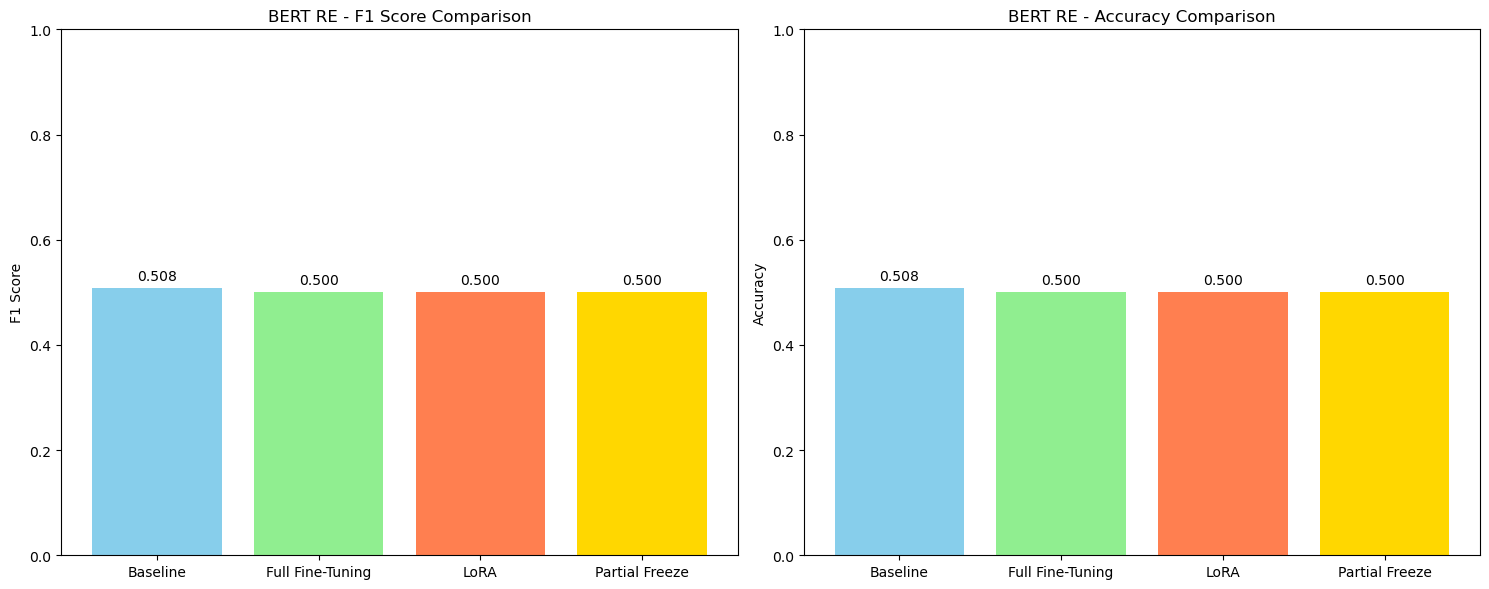


🏆 Best performing method: Baseline
   F1 Score: 0.5083
   Accuracy: 0.5083


In [19]:
# Compile results
results_summary = {
    "Method": ["Baseline", "Full Fine-Tuning", "LoRA", "Partial Freeze"],
    "Dev F1": [
        baseline_results["eval_f1"],
        final_ft_results["eval_f1"],
        final_lora_results["eval_f1"],
        final_freeze_results["eval_f1"]
    ],
    "Dev Accuracy": [
        baseline_results["eval_accuracy"],
        final_ft_results["eval_accuracy"],
        final_lora_results["eval_accuracy"],
        final_freeze_results["eval_accuracy"]
    ]
}

results_df = pd.DataFrame(results_summary)
print("\n" + "="*50)
print("BERT RELATION EXTRACTION - FINAL RESULTS")
print("="*50)
print(results_df.to_string(index=False, float_format='%.4f'))

# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# F1 Score comparison
ax1.bar(results_df["Method"], results_df["Dev F1"], color=['skyblue', 'lightgreen', 'coral', 'gold'])
ax1.set_title("BERT RE - F1 Score Comparison")
ax1.set_ylabel("F1 Score")
ax1.set_ylim(0, 1)
for i, v in enumerate(results_df["Dev F1"]):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Accuracy comparison
ax2.bar(results_df["Method"], results_df["Dev Accuracy"], color=['skyblue', 'lightgreen', 'coral', 'gold'])
ax2.set_title("BERT RE - Accuracy Comparison")
ax2.set_ylabel("Accuracy")
ax2.set_ylim(0, 1)
for i, v in enumerate(results_df["Dev Accuracy"]):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Best performing method
best_method_idx = np.argmax(results_df["Dev F1"])
best_method = results_df.iloc[best_method_idx]
print(f"\n🏆 Best performing method: {best_method['Method']}")
print(f"   F1 Score: {best_method['Dev F1']:.4f}")
print(f"   Accuracy: {best_method['Dev Accuracy']:.4f}")

## 13. Hyperparameter Analysis


HYPERPARAMETER ANALYSIS

📊 Full Fine-Tuning Best Parameters:
  learning_rate: 1.2865942200426882e-05
  batch_size: 16

📊 LoRA Best Parameters:
  learning_rate: 0.0003384691774994889
  r: 16
  alpha: 16
  dropout: 0.0988765418092483
  batch_size: 16

📊 Partial Freeze Best Parameters:
  learning_rate: 4.4813889241537596e-05
  batch_size: 8
  freeze_pct: 0.29816094974026214


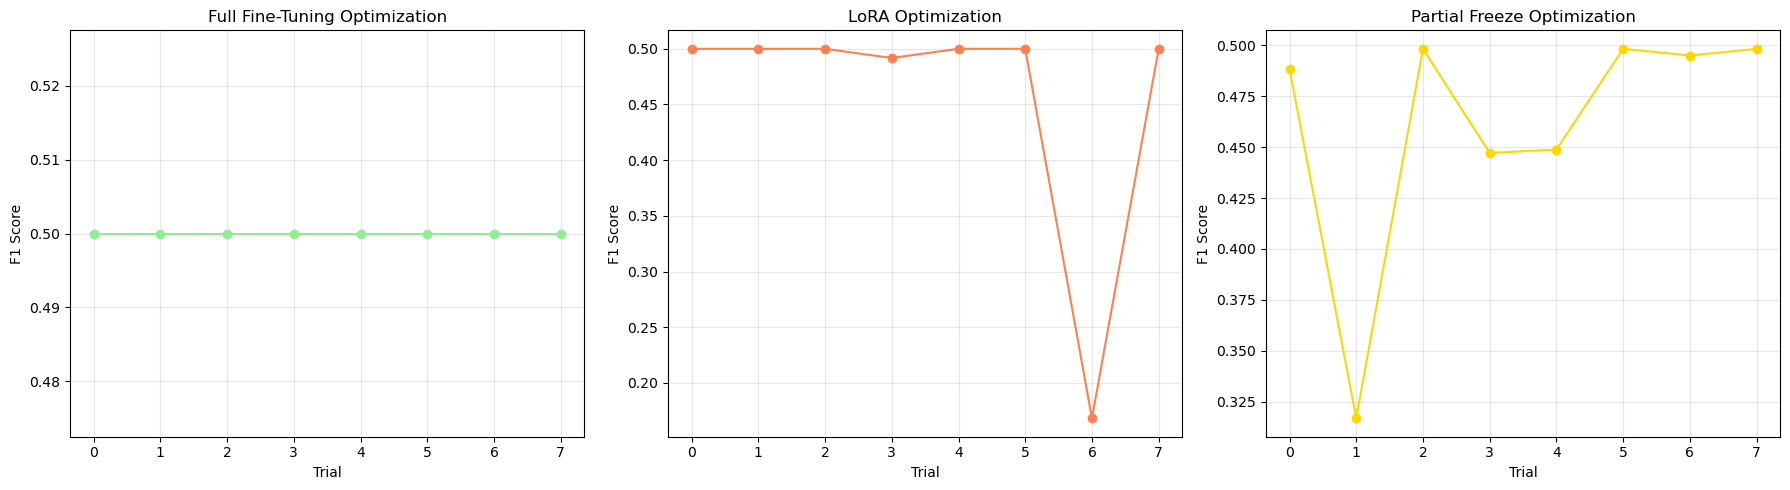

In [20]:
# Analyze hyperparameter importance
print("\n" + "="*50)
print("HYPERPARAMETER ANALYSIS")
print("="*50)

print("\n📊 Full Fine-Tuning Best Parameters:")
for param, value in best_ft_params.items():
    print(f"  {param}: {value}")

print(f"\n📊 LoRA Best Parameters:")
for param, value in best_lora_params.items():
    print(f"  {param}: {value}")

print(f"\n📊 Partial Freeze Best Parameters:")
for param, value in best_freeze_params.items():
    print(f"  {param}: {value}")

# Plot hyperparameter optimization history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Full FT optimization history
ft_values = [trial.value for trial in study_ft.trials if trial.value is not None]
axes[0].plot(ft_values, 'o-', color='lightgreen')
axes[0].set_title('Full Fine-Tuning Optimization')
axes[0].set_xlabel('Trial')
axes[0].set_ylabel('F1 Score')
axes[0].grid(True, alpha=0.3)

# LoRA optimization history
lora_values = [trial.value for trial in study_lora.trials if trial.value is not None]
axes[1].plot(lora_values, 'o-', color='coral')
axes[1].set_title('LoRA Optimization')
axes[1].set_xlabel('Trial')
axes[1].set_ylabel('F1 Score')
axes[1].grid(True, alpha=0.3)

# Freeze optimization history
freeze_values = [trial.value for trial in study_freeze.trials if trial.value is not None]
axes[2].plot(freeze_values, 'o-', color='gold')
axes[2].set_title('Partial Freeze Optimization')
axes[2].set_xlabel('Trial')
axes[2].set_ylabel('F1 Score')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()